In [1]:
import pandas as pd
import numpy as np
import string
import re
import itertools
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import en_core_web_sm
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.feature_extraction import text
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Functions

##### Preprocessing

In [2]:
def preprocess(text):
    text = text.str.lower()
    text = text.str.replace("(<br/>)", "")
    text = text.str.replace('(<a).*(>).*(</a>)', '')
    text = text.str.replace('(&amp)', '')
    text = text.str.replace('(&gt)', '')
    text = text.str.replace('(&lt)', '')
    text = text.str.replace('(\xa0)', ' ')
    return text

##### Some functions for frequency plotting

In [3]:
# count term frequencies and return in descending order
def termCount(data, targetVar):
    count = data.groupby([targetVar])[targetVar].agg(
        ['count']).sort_values(by=['count'],ascending=False
                              ).reset_index()
    return count

# plot top N terms
def plotTopTerms(data, targetVar, ax=None, n=20, title=None):
    if ax is None:
        ax = plt.figure()
    ax = sns.catplot(x="count", y=targetVar, hue = None, color='#006EAD',
                     kind="bar", data=data[0:n])
    ax.set(xlabel='count', ylabel='', title = title)

##### Perprocess text

In [182]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

##### Flatten list of lists

In [20]:
def flattenList(listIn):
    listOut = [item for sublist in listIn for item in sublist]
    return listOut

##### Frequency plotting

In [ ]:
# count term frequencies and return in descending order
def termCount(data, targetVar):
    count = data.groupby([targetVar])[targetVar].agg(
        ['count']).sort_values(by=['count'],ascending=False
                              ).reset_index()
    return count

# plot top N terms
def plotTopTerms(data, targetVar, ax=None, n=20, title=None):
    if ax is None:
        ax = plt.figure()
    ax = sns.catplot(x="count", y=targetVar, hue = None, color='#006EAD',
                     kind="bar", data=data[0:n])
    ax.set(xlabel='count', ylabel='', title = title)

## Read in data

In [4]:
gd_data = pd.read_csv('../data/glassdoortest1.csv',
                     encoding = "ISO-8859-1")
# remove first column w/ redundant indices
gd_data = gd_data.iloc[:, 1:]

In [5]:
gd_data.head()

,date,title,pros,cons
0,13-Apr-18,Good Company to Work For,"Great Pay, Flexible Hours, Unlimited Vacation.","Health Care, 401K, nothing else really"
1,16-Apr-18,First Impressions,Great staff and very helpful. Fair compensatio...,As a relatively new employee I have not experi...
2,12-Apr-18,Sr. Engineering Technologist,"Great benefits, working condition and people!",Must make a 30 mile commute.
3,11-Apr-18,Environmental Specialist,Very supportive environment for learning new t...,Corporate is slow in taking decisions
4,12-Apr-18,Sales,"Work Life Balance, Slightly above average pay,...","High health care cost, high employee cost of c..."


In [6]:
gd_data.describe()

,date,title,pros,cons
count,2000,1995,2000,2000
unique,669,1234,1475,1484
top,31-Jan-18,Honeywell,#NAME?,#NAME?
freq,18,47,31,21


## Clean data

Pros and cons wide to long

In [7]:
gd_data = gd_data.reset_index()
gd_data = pd.melt(gd_data, id_vars=['date', 'title'], 
                  value_vars=['pros', 'cons'], 
                  var_name='pro_vs_con', value_name='review')
gd_data.head()

,date,title,pro_vs_con,review
0,13-Apr-18,Good Company to Work For,pros,"Great Pay, Flexible Hours, Unlimited Vacation."
1,16-Apr-18,First Impressions,pros,Great staff and very helpful. Fair compensatio...
2,12-Apr-18,Sr. Engineering Technologist,pros,"Great benefits, working condition and people!"
3,11-Apr-18,Environmental Specialist,pros,Very supportive environment for learning new t...
4,12-Apr-18,Sales,pros,"Work Life Balance, Slightly above average pay,..."


Explore length (# characters) of reviews

In [8]:
gd_data['length'] = gd_data['review'].apply(len)
gd_data.head()

,date,title,pro_vs_con,review,length
0,13-Apr-18,Good Company to Work For,pros,"Great Pay, Flexible Hours, Unlimited Vacation.",46
1,16-Apr-18,First Impressions,pros,Great staff and very helpful. Fair compensatio...,56
2,12-Apr-18,Sr. Engineering Technologist,pros,"Great benefits, working condition and people!",45
3,11-Apr-18,Environmental Specialist,pros,Very supportive environment for learning new t...,171
4,12-Apr-18,Sales,pros,"Work Life Balance, Slightly above average pay,...",73


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1e7b74d0>,
      dtype=object)

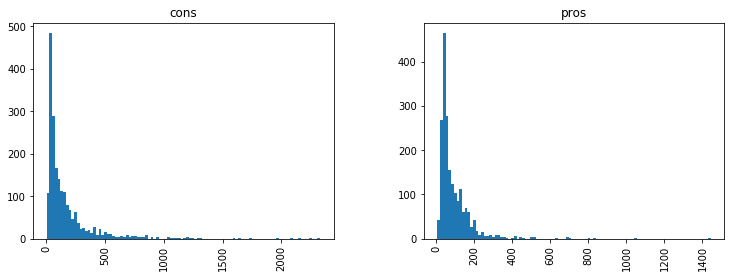

In [9]:
gd_data.hist(column='length', by='pro_vs_con', bins=100,figsize=(12,4))

In [10]:
gd_data.groupby('pro_vs_con').length.describe()

,count,mean,std,min,25%,50%,75%,max
pro_vs_con,,,,,,,,
cons,2000.0,172.2690,236.702984,6.0,47.0,92.0,196.0,2328.0
pros,2000.0,90.9025,91.128487,6.0,40.0,60.0,117.0,1443.0


Most *cons* reviews are longer than *pros* reviews. This is consistent with what I've seen in other employee text data.

What is the date range?

In [11]:
type(gd_data['date'][0])

str

Coerce dates to datetime and find the range

In [12]:
# coerce to date
gd_data['date'] = pd.to_datetime(gd_data['date'])

Text(0.5, 1.0, 'Monthly total reviews over time')

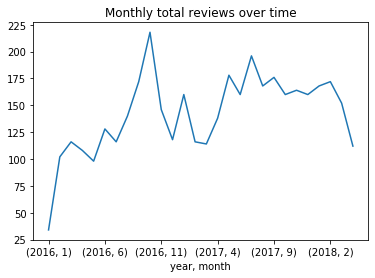

In [13]:
gd_data.groupby([gd_data["date"].dt.year, 
                 gd_data["date"].dt.month]).count().iloc[:, 1].plot(kind='line')
plt.xlabel('year, month')
plt.title('Monthly total reviews over time')

Looks like a nice spread over the 2+ year interval. Helpful for trending over time later.

## Sentiment

Before breaking text into its components, estimate review sentiment using VADER

Load the VADER lexicon

In [14]:
sid = SentimentIntensityAnalyzer()

In [15]:
gd_data['scores'] = gd_data['review'].apply(lambda review: sid.polarity_scores(review))
gd_data['compound']  = gd_data['scores'].apply(lambda score_dict: score_dict['compound'])
gd_data['comp_score'] = gd_data['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')
gd_data.head()

,date,title,pro_vs_con,review,length,scores,compound,comp_score
0,2018-04-13,Good Company to Work For,pros,"Great Pay, Flexible Hours, Unlimited Vacation.",46,"{'neg': 0.135, 'neu': 0.288, 'pos': 0.577, 'co...",0.6808,pos
1,2018-04-16,First Impressions,pros,Great staff and very helpful. Fair compensatio...,56,"{'neg': 0.0, 'neu': 0.338, 'pos': 0.662, 'comp...",0.8680,pos
2,2018-04-12,Sr. Engineering Technologist,pros,"Great benefits, working condition and people!",45,"{'neg': 0.0, 'neu': 0.364, 'pos': 0.636, 'comp...",0.7901,pos
3,2018-04-11,Environmental Specialist,pros,Very supportive environment for learning new t...,171,"{'neg': 0.0, 'neu': 0.929, 'pos': 0.071, 'comp...",0.1893,pos
4,2018-04-12,Sales,pros,"Work Life Balance, Slightly above average pay,...",73,"{'neg': 0.087, 'neu': 0.69, 'pos': 0.222, 'com...",0.4144,pos


### Standardize the text

In [17]:
gd_data_clean = gd_data
gd_data_clean['review_raw'] = gd_data['review']
gd_data_clean = standardize_text(gd_data, "review")
gd_data_clean.to_csv("clean_data.csv")
gd_data_clean.head()

,date,title,pro_vs_con,review,length,scores,compound,comp_score,review_raw
0,2018-04-13,Good Company to Work For,pros,"great pay, flexible hours, unlimited vacation",46,"{'neg': 0.135, 'neu': 0.288, 'pos': 0.577, 'co...",0.6808,pos,"Great Pay, Flexible Hours, Unlimited Vacation."
1,2018-04-16,First Impressions,pros,great staff and very helpful fair compensatio...,56,"{'neg': 0.0, 'neu': 0.338, 'pos': 0.662, 'comp...",0.8680,pos,Great staff and very helpful. Fair compensatio...
2,2018-04-12,Sr. Engineering Technologist,pros,"great benefits, working condition and people!",45,"{'neg': 0.0, 'neu': 0.364, 'pos': 0.636, 'comp...",0.7901,pos,"Great benefits, working condition and people!"
3,2018-04-11,Environmental Specialist,pros,very supportive environment for learning new t...,171,"{'neg': 0.0, 'neu': 0.929, 'pos': 0.071, 'comp...",0.1893,pos,Very supportive environment for learning new t...
4,2018-04-12,Sales,pros,"work life balance, slightly above average pay,...",73,"{'neg': 0.087, 'neu': 0.69, 'pos': 0.222, 'com...",0.4144,pos,"Work Life Balance, Slightly above average pay,..."


### Preprocessing

In [18]:
# list of punctuation marks
punctuations = string.punctuation

# list of stopwords
nlp = spacy.load('en_core_web_sm')

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

Make separate corpora for pro and con reviews

In [19]:
pro_reviews = gd_data_clean.loc[gd_data['pro_vs_con'] == 'pros', 'review']
con_reviews = gd_data_clean.loc[gd_data['pro_vs_con'] == 'cons', 'review']

Function for flattening lists

In [20]:
def flattenList(listIn):
    listOut = [item for sublist in listIn for item in sublist]
    return listOut

Generate language features

In [159]:
tokens = []
lemma = []
pos = []
is_stop = []
pro_vs_con = []
title = []
txt = []
txt_raw = []
sentiment_score = []
entity_txt = []
entity_review = []
entity_lab = []

# iteratively get metrics for each comment
for i in gd_data_clean.index:
    this_pro_v_con = gd_data_clean.loc[i, 'pro_vs_con']
    this_title = gd_data_clean.loc[i, 'title']
    this_text = gd_data_clean.loc[i, 'review']
    this_text_raw = gd_data_clean.loc[i, 'review_raw']
    this_sent = gd_data_clean.loc[i, 'compound']
    doc = nlp(this_text)
    doc_raw = nlp(this_text_raw)
    pro_vs_con.append(list(itertools.repeat(this_pro_v_con, len(doc))))
    title.append(list(itertools.repeat(this_title, len(doc))))
    txt.append(list(itertools.repeat(this_text, len(doc))))
    txt_raw.append(list(itertools.repeat(this_text_raw, len(doc))))
    sentiment_score.append(list(itertools.repeat(this_sent, len(doc))))
    tokens.append([n.text for n in doc])
    lemma.append([n.lemma_ for n in doc])
    pos.append([n.pos_ for n in doc])
    is_stop.append([n.is_stop for n in doc])
    entity_txt.append([n.text for n in doc_raw.ents])
    entity_review.append([doc_raw.text])
    entity_lab.append([n.label_ for n in doc_raw.ents])

In [164]:
doc_raw.text_with

'Daily meeting & the kaizen it makes bit irritation'

In [165]:
# package it all into a pandas data frame for analytic convenience
spacyPreproc_tokens = pd.DataFrame({
    'pro_vs_con': flattenList(pro_vs_con),
    'text': flattenList(txt),
    'text_raw': flattenList(txt_raw),
    'title': flattenList(title), 
    'sentiment': flattenList(sentiment_score),
    'token': flattenList(tokens), 
    'lemma': flattenList(lemma),
    'pos': flattenList(pos),
    'is_stop': flattenList(is_stop)
             })

In [166]:
spacyPreproc_tokens.head(20)

,pro_vs_con,text,text_raw,title,sentiment,token,lemma,pos,is_stop
0,pros,"great pay, flexible hours, unlimited vacation","Great Pay, Flexible Hours, Unlimited Vacation.",Good Company to Work For,0.6808,great,great,ADJ,False
1,pros,"great pay, flexible hours, unlimited vacation","Great Pay, Flexible Hours, Unlimited Vacation.",Good Company to Work For,0.6808,pay,pay,NOUN,False
2,pros,"great pay, flexible hours, unlimited vacation","Great Pay, Flexible Hours, Unlimited Vacation.",Good Company to Work For,0.6808,",",",",PUNCT,False
3,pros,"great pay, flexible hours, unlimited vacation","Great Pay, Flexible Hours, Unlimited Vacation.",Good Company to Work For,0.6808,flexible,flexible,ADJ,False
4,pros,"great pay, flexible hours, unlimited vacation","Great Pay, Flexible Hours, Unlimited Vacation.",Good Company to Work For,0.6808,hours,hour,NOUN,False
5,pros,"great pay, flexible hours, unlimited vacation","Great Pay, Flexible Hours, Unlimited Vacation.",Good Company to Work For,0.6808,",",",",PUNCT,False
6,pros,"great pay, flexible hours, unlimited vacation","Great Pay, Flexible Hours, Unlimited Vacation.",Good Company to Work For,0.6808,unlimited,unlimited,ADJ,False
7,pros,"great pay, flexible hours, unlimited vacation","Great Pay, Flexible Hours, Unlimited Vacation.",Good Company to Work For,0.6808,vacation,vacation,NOUN,False
8,pros,great staff and very helpful fair compensatio...,Great staff and very helpful. Fair compensatio...,First Impressions,0.8680,great,great,ADJ,False
9,pros,great staff and very helpful fair compensatio...,Great staff and very helpful. Fair compensatio...,First Impressions,0.8680,staff,staff,NOUN,False


In [167]:
# filter for "pros" and "cons" entities
cons_entity_txt = [entity_txt[i] for i in np.where(gd_data_clean['pro_vs_con'] == 'cons')[0]]
cons_entity_label = [entity_lab[i] for i in np.where(gd_data_clean['pro_vs_con'] == 'cons')[0]]
cons_review = [txt_raw[i] for i in np.where(gd_data_clean['pro_vs_con'] == 'cons')[0]]
cons_sentiment = [sentiment_score[i] for i in np.where(gd_data_clean['pro_vs_con'] == 'cons')[0]]
pros_entity_txt = [entity_txt[i] for i in np.where(gd_data_clean['pro_vs_con'] == 'pros')[0]]
pros_entity_label = [entity_lab[i] for i in np.where(gd_data_clean['pro_vs_con'] == 'pros')[0]]
pros_review = [txt_raw[i] for i in np.where(gd_data_clean['pro_vs_con'] == 'pros')[0]]
pros_sentiment = [sentiment_score[i] for i in np.where(gd_data_clean['pro_vs_con'] == 'pros')[0]]
# collapse each list of lists into a single list of unique elements
cons_review_clean = [list(pd.unique(x)) for x in cons_review]
cons_sentiment_clean = [list(pd.unique(x)) for x in cons_sentiment]
pros_review_clean = [list(pd.unique(x)) for x in pros_review]
pros_sentiment_clean = [list(pd.unique(x)) for x in cons_sentiment]

In [168]:
cons_entity_txt[5]

['Silo', 'the year']

In [169]:
# build a data frame for each
cons_entities = pd.DataFrame({
    'entity': flattenList(cons_entity_txt),
    'entity_label': flattenList(cons_entity_label)#,
#     'sentiment': cons_sentiment_clean,
#     'review': cons_review_clean
})
pros_entities = pd.DataFrame({
    'entity': flattenList(pros_entity_txt),
    'entity_label': flattenList(pros_entity_label)#,
#     'sentiment': pros_sentiment_clean,
#     'review': pros_review_clean
})

### Term Frequency

Without any further cleaning, what are the most common terms in 'Change' and 'Value' comments?

Most common "change" lemma

<Figure size 1080x360 with 0 Axes>

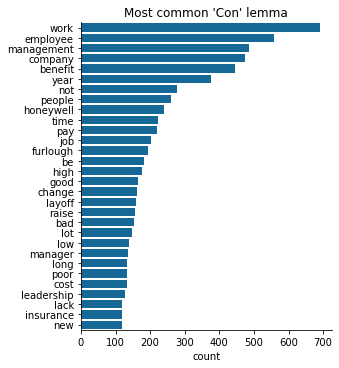

In [183]:
cons_toks = spacyPreproc_tokens[(spacyPreproc_tokens['pos'] != 'PUNCT') &
                                 (spacyPreproc_tokens['pro_vs_con'] == 'cons') &
                                 (~spacyPreproc_tokens['is_stop']) &
                                 ~spacyPreproc_tokens['token'].isin([' ', '', '  '])]
cons_toks_count = termCount(data=cons_toks, targetVar='lemma')
plotTopTerms(data=cons_toks_count, targetVar='lemma', title="Most common 'Con' lemma",
            n=30)

Most common "pros" lemma

<Figure size 1080x360 with 0 Axes>

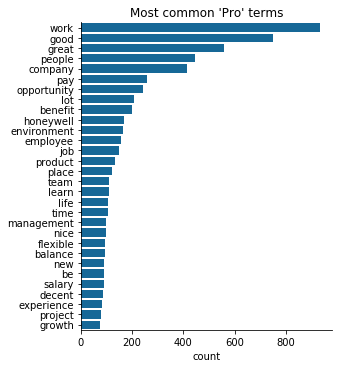

In [184]:
pros_toks = spacyPreproc_tokens[(spacyPreproc_tokens['pos'] != 'PUNCT') &
                                 (spacyPreproc_tokens['pro_vs_con'] == 'pros') &
                                 (~spacyPreproc_tokens['is_stop']) &
                                 ~spacyPreproc_tokens['token'].isin([' ', '', '  '])]
pros_toks_count = termCount(data=pros_toks, targetVar='lemma')
plotTopTerms(data=pros_toks_count, targetVar='lemma', title="Most common 'Pro' terms",
            n=30)

In [185]:
termCount(spacyPreproc_tokens, 'pos')

,pos,count
0,NOUN,26254
1,VERB,16434
2,ADJ,12451
3,ADP,9436
4,DET,6483
5,ADV,6223
6,SPACE,4513
7,PUNCT,4349
8,CCONJ,3266
9,PRON,3221


<Figure size 1080x360 with 0 Axes>

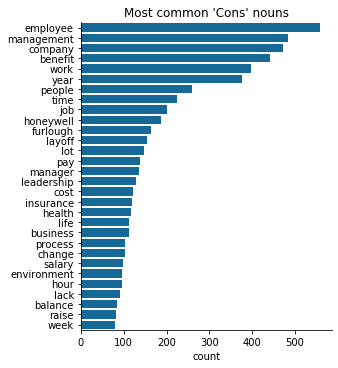

In [186]:
cons_nouns = spacyPreproc_tokens[(spacyPreproc_tokens['pos'] != 'PUNCT') &
                                  (spacyPreproc_tokens['pos'] == 'NOUN') &
                                 (spacyPreproc_tokens['pro_vs_con'] == 'cons') &
                                 (~spacyPreproc_tokens['is_stop']) &
                                 ~spacyPreproc_tokens['token'].isin([' ', '', '  '])]
con_noun_count = termCount(data=cons_nouns, targetVar='lemma')
plotTopTerms(data=con_noun_count, targetVar='lemma', title="Most common 'Cons' nouns",
            n=30)

<Figure size 1080x360 with 0 Axes>

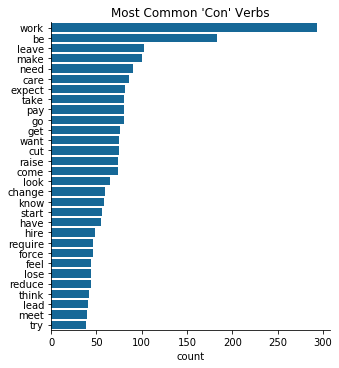

In [187]:
cons_verb = spacyPreproc_tokens[(spacyPreproc_tokens['pos'] != 'PUNCT') &
                                  (spacyPreproc_tokens['pos'] == 'VERB') &
                                 (spacyPreproc_tokens['pro_vs_con'] == 'cons') &
                                 (~spacyPreproc_tokens['is_stop']) &
                                 ~spacyPreproc_tokens['token'].isin([' ', '', '  '])]
con_verb_count = termCount(data=cons_verb, targetVar='lemma')
plotTopTerms(data=con_verb_count, targetVar='lemma', title="Most Common 'Con' Verbs",
            n=30)

<Figure size 1080x360 with 0 Axes>

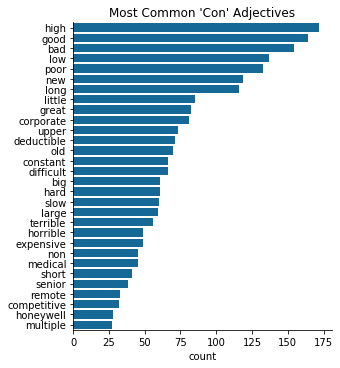

In [188]:
cons_adj = spacyPreproc_tokens[(spacyPreproc_tokens['pos'] != 'PUNCT') &
                                  (spacyPreproc_tokens['pos'] == 'ADJ') &
                                 (spacyPreproc_tokens['pro_vs_con'] == 'cons') &
                                 (~spacyPreproc_tokens['is_stop']) &
                                 ~spacyPreproc_tokens['token'].isin([' ', '', '  '])]
con_adj_count = termCount(data=cons_adj, targetVar='lemma')
plotTopTerms(data=con_adj_count, targetVar='lemma', title="Most Common 'Con' Adjectives",
            n=30)

<Figure size 1080x360 with 0 Axes>

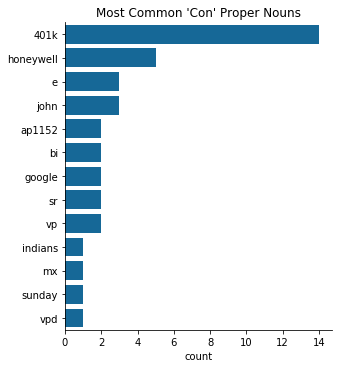

In [189]:
cons_propn = spacyPreproc_tokens[(spacyPreproc_tokens['pos'] != 'PUNCT') &
                                  (spacyPreproc_tokens['pos'] == 'PROPN') &
                                 (spacyPreproc_tokens['pro_vs_con'] == 'cons') &
                                 (~spacyPreproc_tokens['is_stop']) &
                                 ~spacyPreproc_tokens['token'].isin([' ', '', '  '])]
con_propn_count = termCount(data=cons_propn, targetVar='lemma')
plotTopTerms(data=con_propn_count, targetVar='lemma', title="Most Common 'Con' Proper Nouns")

<Figure size 1080x360 with 0 Axes>

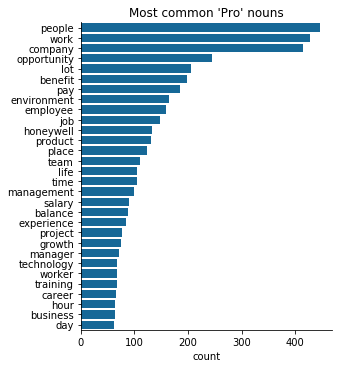

In [190]:
pros_nouns = spacyPreproc_tokens[(spacyPreproc_tokens['pos'] != 'PUNCT') &
                                  (spacyPreproc_tokens['pos'] == 'NOUN') &
                                 (spacyPreproc_tokens['pro_vs_con'] == 'pros') &
                                 (~spacyPreproc_tokens['is_stop']) &
                                 ~spacyPreproc_tokens['token'].isin([' ', '', '  '])]
pro_noun_count = termCount(data=pros_nouns, targetVar='lemma')
plotTopTerms(data=pro_noun_count, targetVar='lemma', title="Most common 'Pro' nouns", 
             n=30)

<Figure size 1080x360 with 0 Axes>

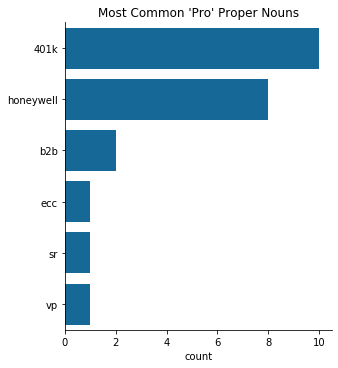

In [191]:
pros_propn = spacyPreproc_tokens[(spacyPreproc_tokens['pos'] != 'PUNCT') &
                                  (spacyPreproc_tokens['pos'] == 'PROPN') &
                                 (spacyPreproc_tokens['pro_vs_con'] == 'pros') &
                                 (~spacyPreproc_tokens['is_stop']) &
                                 ~spacyPreproc_tokens['token'].isin([' ', '', '  '])]
pro_propn_count = termCount(data=pros_propn, targetVar='lemma')
plotTopTerms(data=pro_propn_count, targetVar='lemma', title="Most Common 'Pro' Proper Nouns")

### Most commen entities

<Figure size 432x288 with 0 Axes>

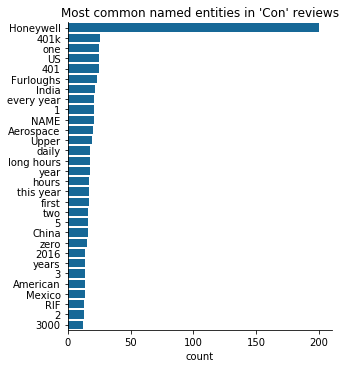

In [170]:
cons_entities_clean = cons_entities[~cons_entities['entity'].isin([' ', '', '  '])]
cons_ent_count = termCount(data=cons_entities_clean, targetVar='entity')
plotTopTerms(data=cons_ent_count, targetVar='entity', 
             title = "Most common named entities in 'Con' reviews",
            n=30)

<Figure size 432x288 with 0 Axes>

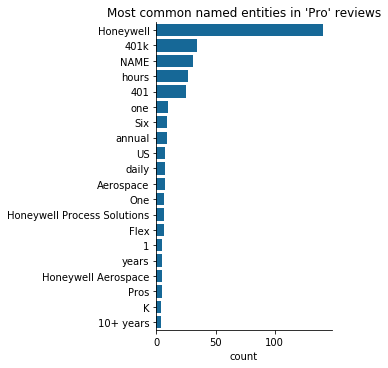

In [171]:
pros_entities_clean = pros_entities[~pros_entities['entity'].isin([' ', '', '  '])]
pros_ent_count = termCount(data=pros_entities_clean, targetVar='entity')
plotTopTerms(data=pros_ent_count, targetVar='entity', title = "Most common named entities in 'Pro' reviews")

In [172]:
cons_entities_clean

,entity,entity_label
0,Health Care,ORG
1,401,CARDINAL
2,30 mile,QUANTITY
3,Silo,ORG
4,the year,DATE
...,...,...
2232,Furloughs,ORG
2233,2016,DATE
2234,Industrial Safety,ORG
2235,long hours,TIME


In [173]:
top_con_entlabs = cons_entities_clean.groupby('entity_label').size().sort_values(ascending=False).reset_index(name='count')
top_con_entlabs = top_con_entlabs[top_con_entlabs['count'] > 5]
top_con_entlabs

,entity_label,count
0,DATE,663
1,ORG,593
2,CARDINAL,334
3,GPE,167
4,PERSON,109
5,TIME,98
6,PERCENT,78
7,MONEY,64
8,NORP,48
9,ORDINAL,25


In [174]:
cons_entity_count = cons_entities_clean.groupby(['entity', 'entity_label']).size().sort_values().reset_index(name='count')

[Text(0, 0.5, ''), Text(0.5, 0, 'count'), Text(0.5, 1.0, 'NORP')]

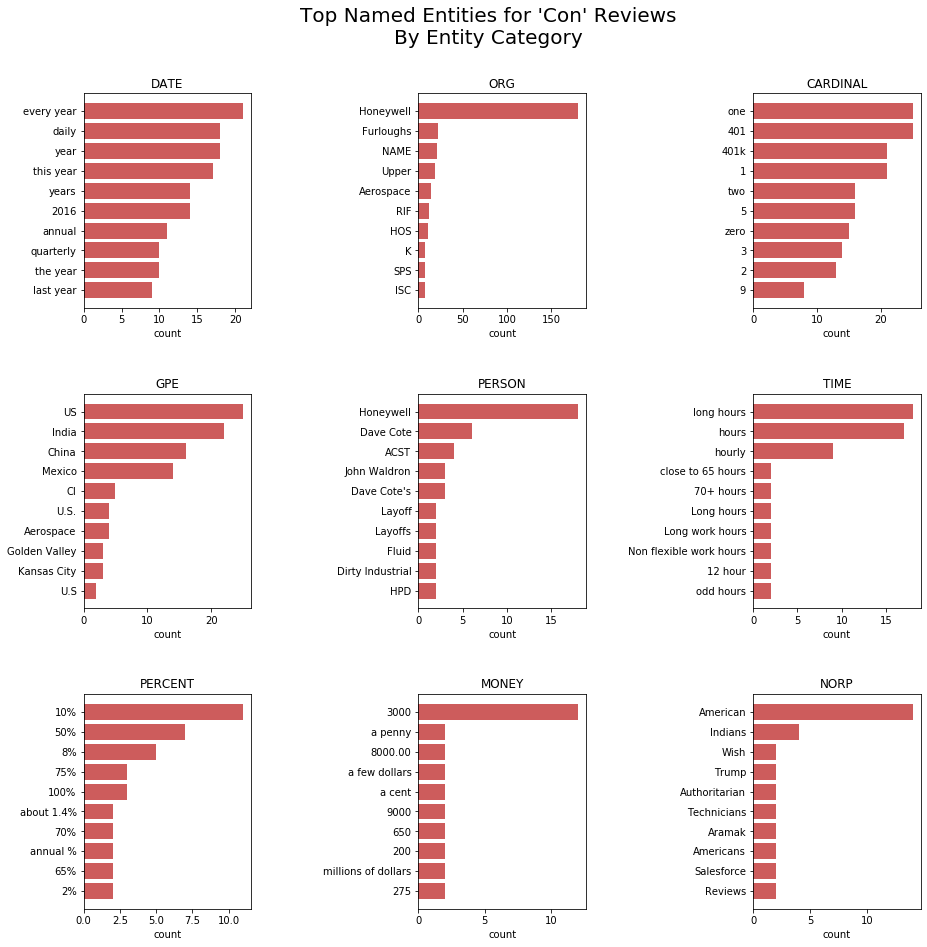

In [176]:
fig = plt.figure()
plt.rcParams['figure.figsize'] = [15,15]
plt.rcParams["font.weight"] = "regular"
plt.subplots_adjust(wspace=1, hspace=.4)
fig.suptitle("Top Named Entities for 'Con' Reviews\nBy Entity Category", fontsize=20,color="black", 
             position=(0.5,0.96))

ax1 = fig.add_subplot(331)
ax1.barh('entity', 'count', data=cons_entity_count.loc[
    cons_entity_count['entity_label'] == top_con_entlabs.loc[0, 'entity_label'], 
                         ['entity', 'entity_label', 'count']][-10:], color = 'indianred')
ax1.set(xlabel='count', ylabel='', title = top_con_entlabs.loc[0, 'entity_label'])

ax2 = fig.add_subplot(332)
ax2.barh('entity', 'count', data=cons_entity_count.loc[
    cons_entity_count['entity_label'] == top_con_entlabs.loc[1, 'entity_label'], 
                         ['entity', 'entity_label', 'count']][-10:], color = 'indianred')
ax2.set(xlabel='count', ylabel='', title = top_con_entlabs.loc[1, 'entity_label'])

ax3 = fig.add_subplot(333)
ax3.barh('entity', 'count', data=cons_entity_count.loc[
    cons_entity_count['entity_label'] == top_con_entlabs.loc[2, 'entity_label'], 
                         ['entity', 'entity_label', 'count']][-10:], color = 'indianred')
ax3.set(xlabel='count', ylabel='', title = top_con_entlabs.loc[2, 'entity_label'])

ax4 = fig.add_subplot(334)
ax4.barh('entity', 'count', data=cons_entity_count.loc[
    cons_entity_count['entity_label'] == top_con_entlabs.loc[3, 'entity_label'], 
                         ['entity', 'entity_label', 'count']][-10:], color = 'indianred')
ax4.set(xlabel='count', ylabel='', title = top_con_entlabs.loc[3, 'entity_label'])

ax5 = fig.add_subplot(335)
ax5.barh('entity', 'count', data=cons_entity_count.loc[
    cons_entity_count['entity_label'] == top_con_entlabs.loc[4, 'entity_label'], 
                         ['entity', 'entity_label', 'count']][-10:], color = 'indianred')
ax5.set(xlabel='count', ylabel='', title = top_con_entlabs.loc[4, 'entity_label'])

ax6 = fig.add_subplot(336)
ax6.barh('entity', 'count', data=cons_entity_count.loc[
    cons_entity_count['entity_label'] == top_con_entlabs.loc[5, 'entity_label'], 
                         ['entity', 'entity_label', 'count']][-10:], color = 'indianred')
ax6.set(xlabel='count', ylabel='', title = top_con_entlabs.loc[5, 'entity_label'])

ax7 = fig.add_subplot(337)
ax7.barh('entity', 'count', data=cons_entity_count.loc[
    cons_entity_count['entity_label'] == top_con_entlabs.loc[6, 'entity_label'], 
                         ['entity', 'entity_label', 'count']][-10:], color = 'indianred')
ax7.set(xlabel='count', ylabel='', title = top_con_entlabs.loc[6, 'entity_label'])

ax8 = fig.add_subplot(338)
ax8.barh('entity', 'count', data=cons_entity_count.loc[
    cons_entity_count['entity_label'] == top_con_entlabs.loc[7, 'entity_label'], 
                         ['entity', 'entity_label', 'count']][-10:], color = 'indianred')
ax8.set(xlabel='count', ylabel='', title = top_con_entlabs.loc[7, 'entity_label'])

ax9 = fig.add_subplot(339)
ax9.barh('entity', 'count', data=cons_entity_count.loc[
    cons_entity_count['entity_label'] == top_con_entlabs.loc[8, 'entity_label'], 
                         ['entity', 'entity_label', 'count']][-10:], color = 'indianred')
ax9.set(xlabel='count', ylabel='', title = top_con_entlabs.loc[8, 'entity_label'])

In [177]:
top_pro_entlabs = pros_entities_clean.groupby('entity_label').size().sort_values(ascending=False).reset_index(name='count')
top_pro_entlabs = top_pro_entlabs[top_pro_entlabs['count'] > 10]
top_pro_entlabs

,entity_label,count
0,ORG,426
1,DATE,168
2,CARDINAL,135
3,TIME,57
4,GPE,46
5,PERSON,43
6,PERCENT,13


In [178]:
pro_entity_count = pros_entities_clean.groupby(['entity', 'entity_label']).size().sort_values().reset_index(name='count')

In [179]:
pro_entity_count.loc[
    pro_entity_count['entity_label'] == top_pro_entlabs.loc[0, 'entity_label'], 
                         ['entity', 'entity_label', 'count']][-20:]

,entity,entity_label,count
362,Unlimited Vacation,ORG,2
363,"Unlimited Vacation, Advancement Opportunities",ORG,2
367,Vision and Dental,ORG,2
369,Field Service Techs,ORG,2
373,Im,ORG,2
374,Fantastic Management,ORG,2
376,Vacation,ORG,3
378,Great Company,ORG,3
382,Great,ORG,3
383,Coworkers,ORG,3


[Text(0, 0.5, ''), Text(0.5, 0, 'count'), Text(0.5, 1.0, 'CARDINAL')]

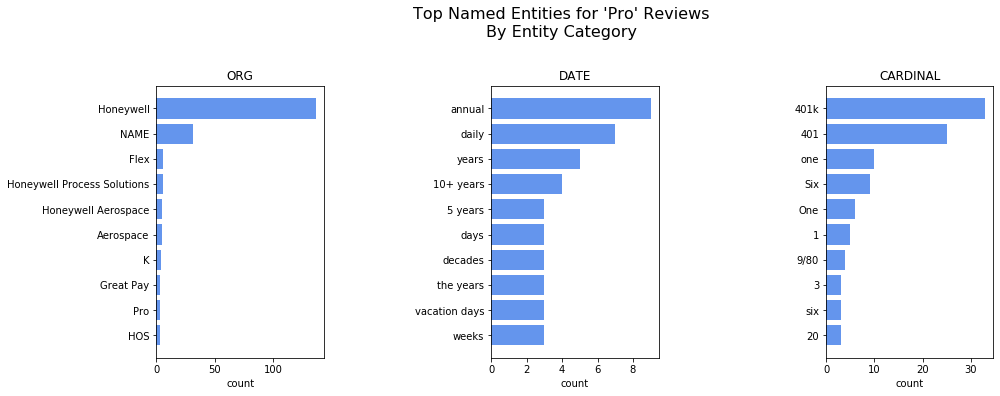

In [181]:
fig = plt.figure()
plt.rcParams['figure.figsize'] = [15,5]
plt.rcParams["font.weight"] = "regular"
plt.subplots_adjust(wspace=1, hspace=.5)
fig.suptitle("Top Named Entities for 'Pro' Reviews\nBy Entity Category", fontsize=16,color="black", 
             position=(0.5,1.1))

ax1 = fig.add_subplot(131)
ax1.barh('entity', 'count', data=pro_entity_count.loc[
    pro_entity_count['entity_label'] == top_pro_entlabs.loc[0, 'entity_label'], 
                         ['entity', 'entity_label', 'count']][-10:], color = 'cornflowerblue')
ax1.set(xlabel='count', ylabel='', title = top_pro_entlabs.loc[0, 'entity_label'])

ax2 = fig.add_subplot(132)
ax2.barh('entity', 'count', data=pro_entity_count.loc[
    pro_entity_count['entity_label'] == top_pro_entlabs.loc[1, 'entity_label'], 
                         ['entity', 'entity_label', 'count']][-10:], color = 'cornflowerblue')
ax2.set(xlabel='count', ylabel='', title = top_pro_entlabs.loc[1, 'entity_label'])

ax3 = fig.add_subplot(133)
ax3.barh('entity', 'count', data=pro_entity_count.loc[
    pro_entity_count['entity_label'] == top_pro_entlabs.loc[2, 'entity_label'], 
                         ['entity', 'entity_label', 'count']][-10:], color = 'cornflowerblue')
ax3.set(xlabel='count', ylabel='', title = top_pro_entlabs.loc[2, 'entity_label'])

# Next Steps
* tie the named entities back to the indivual reviews that contain them for document retrieval
* use word embeddings (word2vec?) to calculate cosine similarity between retrieved doc and all other docs and surface all docs that are similar
* compare utility of insights to LDA, NMF, and/or clustering by embeddings